In [1]:
import yfinance as yf
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as sco
plt.style.use('fivethirtyeight')
np.random.seed(777)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
port_stock = "AMD CLF CSCO PFE USA"
data = yf.download( port_stock , start="2018-04-04", end="2019-04-04" )

[*********************100%***********************]  5 of 5 completed


In [3]:
table = data['Adj Close']
table

,AMD,CLF,CSCO,PFE,USA
Date,,,,,
2018-04-03,9.550000,6.667012,39.347317,33.523754,5.069098
2018-04-04,9.770000,6.647631,39.491096,33.946552,5.127363
2018-04-05,10.020000,6.986796,40.085377,33.570732,5.193952
2018-04-06,9.610000,6.647631,39.040592,33.044571,5.069098
2018-04-09,9.530000,6.521656,39.462341,33.317043,5.119040
...,...,...,...,...,...
2019-03-28,25.059999,9.479394,52.295658,41.132168,5.621598
2019-03-29,25.520000,9.742710,52.913094,41.307240,5.649337
2019-04-01,26.360001,10.123056,53.883347,41.667114,5.723305


/home/zeabus/anaconda3/envs/finance/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'price in $')

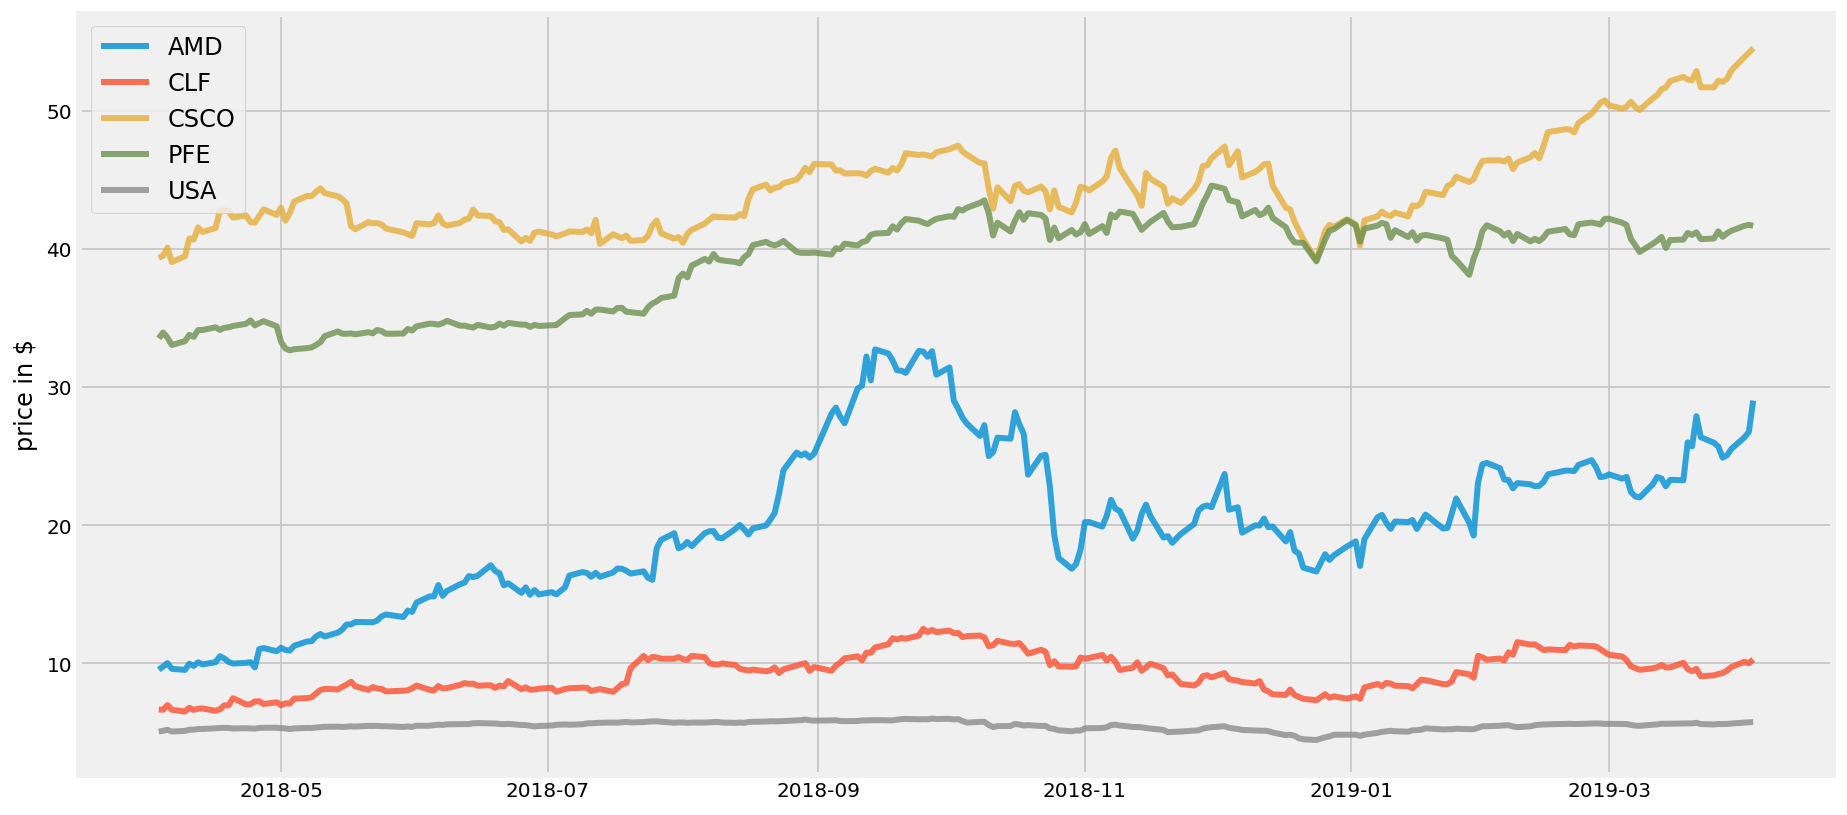

In [4]:
plt.figure(figsize=(14, 7))
for c in table.columns.values:
    plt.plot(table.index, table[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('price in $')

Text(0, 0.5, 'daily returns')

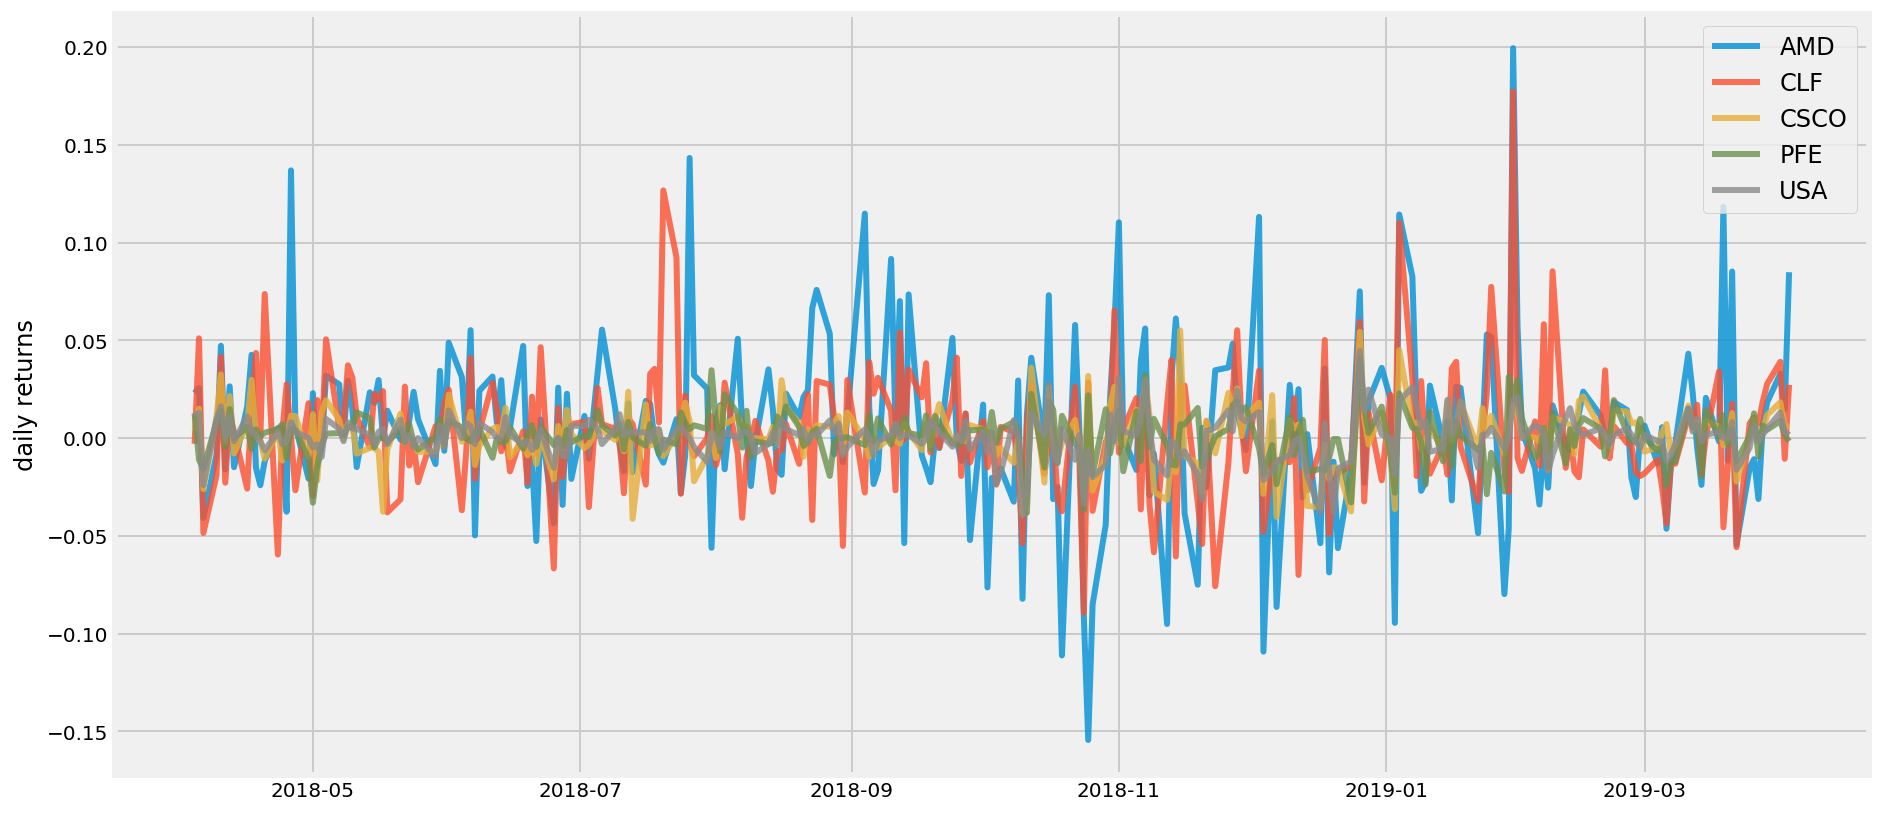

In [5]:
returns = table.pct_change()
plt.figure(figsize=(14, 7))
for c in returns.columns.values:
    plt.plot(returns.index, returns[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper right', fontsize=12)
plt.ylabel('daily returns')

In [6]:
returns

,AMD,CLF,CSCO,PFE,USA
Date,,,,,
2018-04-03,NaN,NaN,NaN,NaN,NaN
2018-04-04,0.023037,-0.002907,0.003654,0.012612,0.011494
2018-04-05,0.025589,0.051020,0.015048,-0.011071,0.012987
2018-04-06,-0.040918,-0.048544,-0.026064,-0.015673,-0.024038
2018-04-09,-0.008325,-0.018950,0.010803,0.008246,0.009852
...,...,...,...,...,...
2019-03-28,0.006830,0.018868,0.004140,0.006426,0.001647
2019-03-29,0.018356,0.027778,0.011807,0.004256,0.004934
2019-04-01,0.032915,0.039039,0.018337,0.008712,0.013093


# PART OF MINIMIZE

In [7]:
# define important variable
global mean_returns, cov_matrix
returns = table.pct_change()
mean_returns = returns.mean()
var_returns = returns.var()
cov_matrix = returns.cov()
bound_weight = (0.0 , 1.0 )
num_portfolios = 25000
risk_free_rate = 0
number_of_case = 200

In [8]:
# Below function will return std and return of portfolio
global multiple_constant, target_return, target_variance
multiple_constant = 1 # original 252
def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    global multiple_constant
    returns = np.sum( mean_returns*weights ) * multiple_constant
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt( multiple_constant )
    return std**2, returns

def target_portfolio_return( weights ):
    global mean_returns, mean_returns, target_return
    return target_return - portfolio_annualised_performance( weights , mean_returns , cov_matrix )[1]

def target_portfolio_variance( weights ):
    global cov_matrix, mean_returns, target_variance
    return target_variance - portfolio_annualised_performance( weights , mean_returns , cov_matrix )[0]
  
def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((3,num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(5)
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return results, weights_record

In [9]:
# define function for constant
constrain_weight = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
constrain_variance = {'type' : 'eq' , 'fun' : target_portfolio_variance }
constrain_returns = {'type' : 'eq' , 'fun' : target_portfolio_return }

## Return Objective
minimice variance by focuse on weight and return

In [10]:
def portfolio_volatility(weights, mean_returns, cov_matrix):
    return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[0]

def minimum_variance( mean_returns, cov_matrix , focus_return ):
    global target_return
    target_return = focus_return
    args = (mean_returns, cov_matrix)
    num_assets = len( mean_returns )
    bound = bound_weight
    bounds = tuple(bound for asset in range(num_assets))
    constraints = ( constrain_weight , constrain_returns )
    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result

In [11]:
minimum_variance( mean_returns , cov_matrix , 0.003 )['x']

array([0.39841748, 0.20835286, 0.15784268, 0.12909987, 0.10628711])

### Plot efficient frontier

In [12]:
min_value = np.amin( mean_returns )
max_value = np.amax( mean_returns )
diff_value = ( max_value - min_value ) / number_of_case

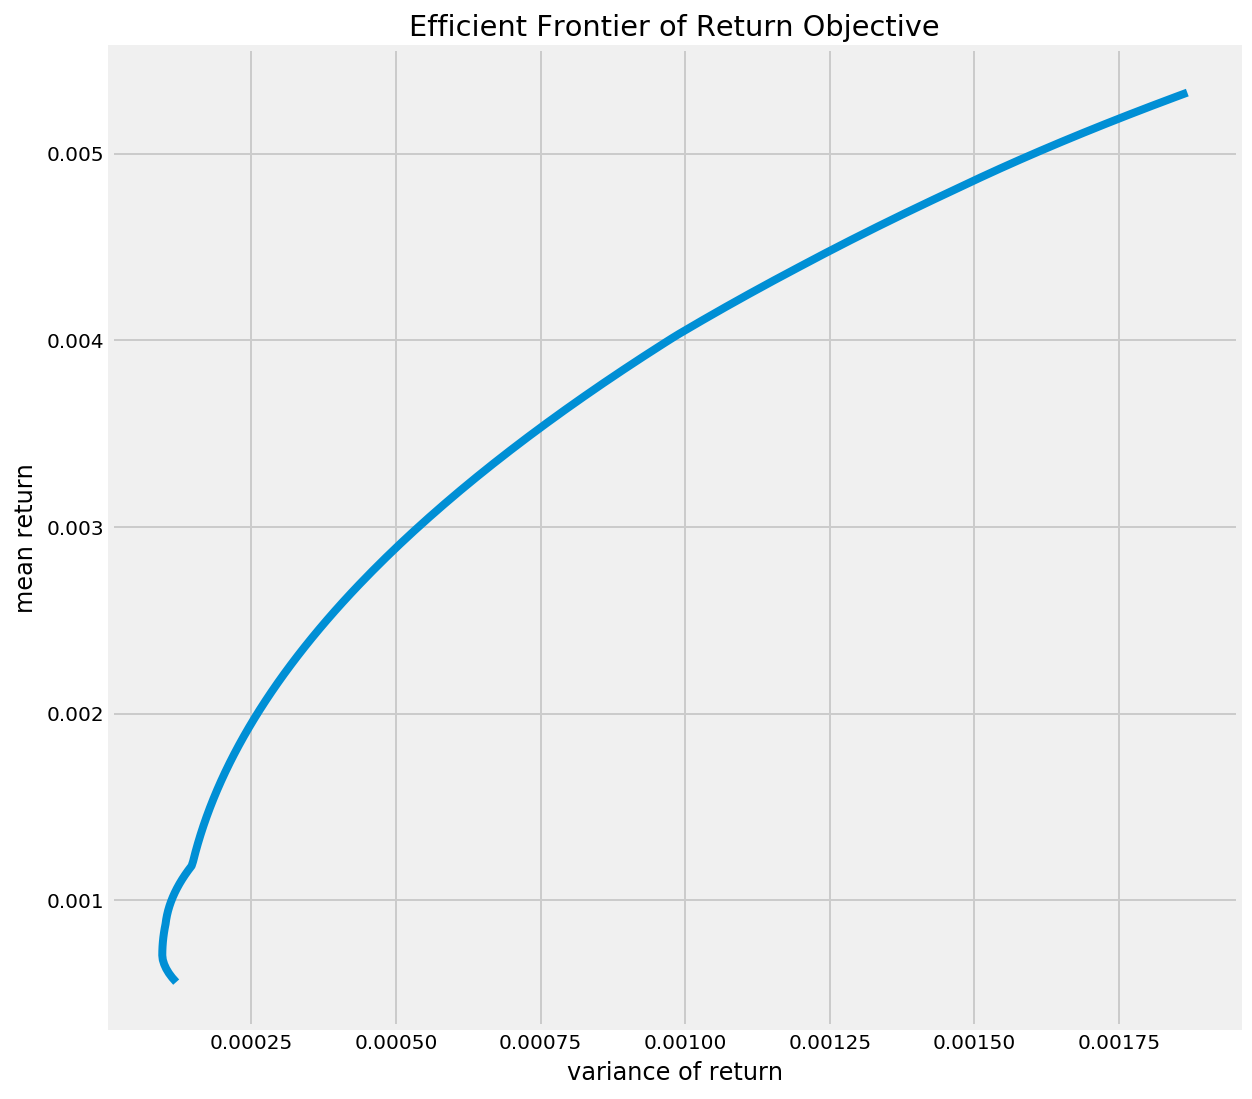

In [13]:
expect_return_return = np.array( [] )
expect_return_risk = np.array( [] )
for target_return in np.arange( min_value , max_value , diff_value ):
    temp_result = minimum_variance( mean_returns , cov_matrix , target_return )
    expect_return_return = np.append( 
            expect_return_return,
            target_return )
    expect_return_risk = np.append(
            expect_return_risk,
            temp_result.fun )
    
plt.figure(figsize = ( 9 , 9 ))
plt.plot( expect_return_risk , expect_return_return )
plt.title('Efficient Frontier of Return Objective')
plt.xlabel( "variance of return")
plt.ylabel( "mean return")
plt.show()   

## Risk Constrain
miximum about return by focus on weight and risk

In [14]:
def neg_portfolio_return( weights, mean_returns, cov_matrix ):
    return -1.0 * portfolio_annualised_performance(weights, mean_returns, cov_matrix)[1]

def maximum_return( mean_returns, cov_matrix , focus_variance ):
    global target_variance
    target_variance = focus_variance
    args = (mean_returns, cov_matrix)
    num_assets = len( mean_returns )
    bound = bound_weight
    bounds = tuple(bound for asset in range(num_assets))
    constraints = ( constrain_weight , constrain_variance )
    result = sco.minimize( neg_portfolio_return, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    result['fun'] *= -1.0
    return result

In [15]:
maximum_return( mean_returns , cov_matrix , 0.0006 )['x']

array([0.40670469, 0.27461588, 0.13282108, 0.08703868, 0.09881967])

### Plot efficient frontier

In [16]:
min_value = np.amin( var_returns )
max_value = np.amax( var_returns )
diff_value = ( max_value - min_value ) / number_of_case

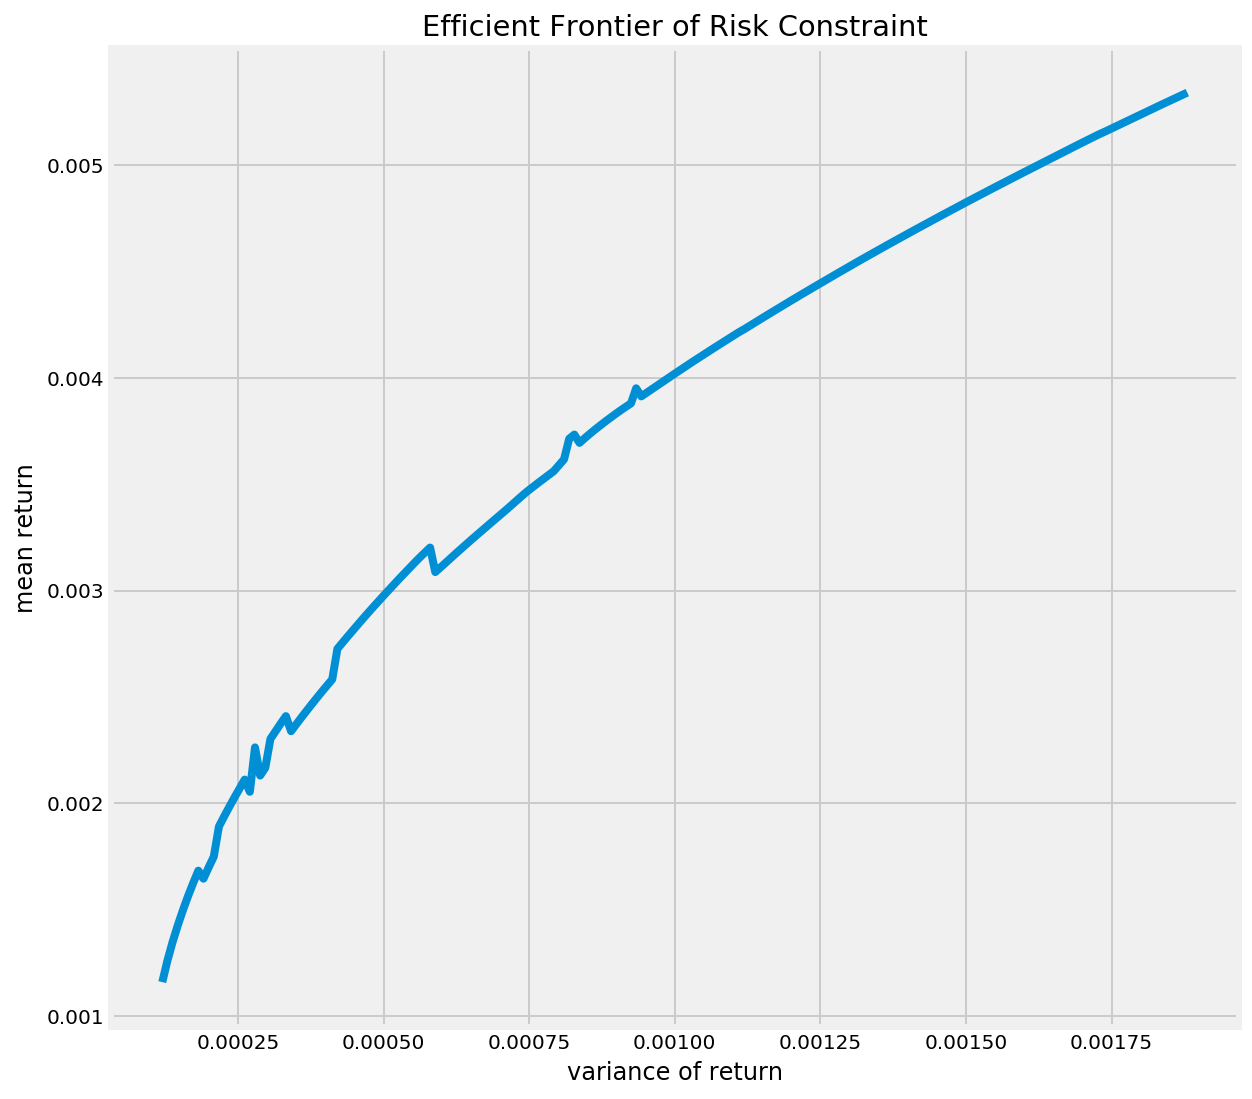

In [17]:
risk_return_return = np.array( [] )
risk_return_risk = np.array( [] )
for target_risk in np.arange( min_value , max_value , diff_value ):
    temp_result = maximum_return( mean_returns, cov_matrix , target_risk )
    risk_return_return = np.append( 
            risk_return_return,
            temp_result.fun )
    risk_return_risk = np.append(
            risk_return_risk,
            target_risk )
    
plt.figure(figsize = ( 9 , 9 ))
plt.plot( risk_return_risk , risk_return_return )
plt.title('Efficient Frontier of Risk Constraint')
plt.xlabel( "variance of return")
plt.ylabel( "mean return")
plt.show()   

## Mean-Variance Optimization

In [18]:
def neg_mean_variance_optimization( weights, mean_returns, cov_matrix , coefficient ):
    port_return, port_variance = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
    return -port_return + coefficient / 2.0 * port_variance

def maximum_optimization( mean_returns, cov_matrix, coefficient ):
    args = (mean_returns, cov_matrix , coefficient )
    num_assets = len( mean_returns )
    bound = bound_weight
    bounds = tuple(bound for asset in range(num_assets))
    constraints = ( constrain_weight )
    result = sco.minimize( neg_mean_variance_optimization, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    result['fun'] *= -1.0
    return result

In [19]:
for coefficient in [ 0.5 , 1.2 , 2.3 ]:
    result = maximum_optimization( mean_returns , cov_matrix , coefficient )
    print( "Case coefficient is " + str( coefficient ) + 
         " get weight is " + repr( result.x ) )

Case coefficient is 0.5 get weight is array([0.2, 0.2, 0.2, 0.2, 0.2])
Case coefficient is 1.2 get weight is array([0.        , 0.22065082, 0.23077382, 0.25356911, 0.29500625])
Case coefficient is 2.3 get weight is array([8.56474283e-16, 3.05311332e-16, 1.89654976e-01, 3.33049581e-01,
       4.77295443e-01])


### Plot efficient frontier

In [20]:
min_value = -2
max_value = 2
diff_value = (max_value - min_value) / number_of_case

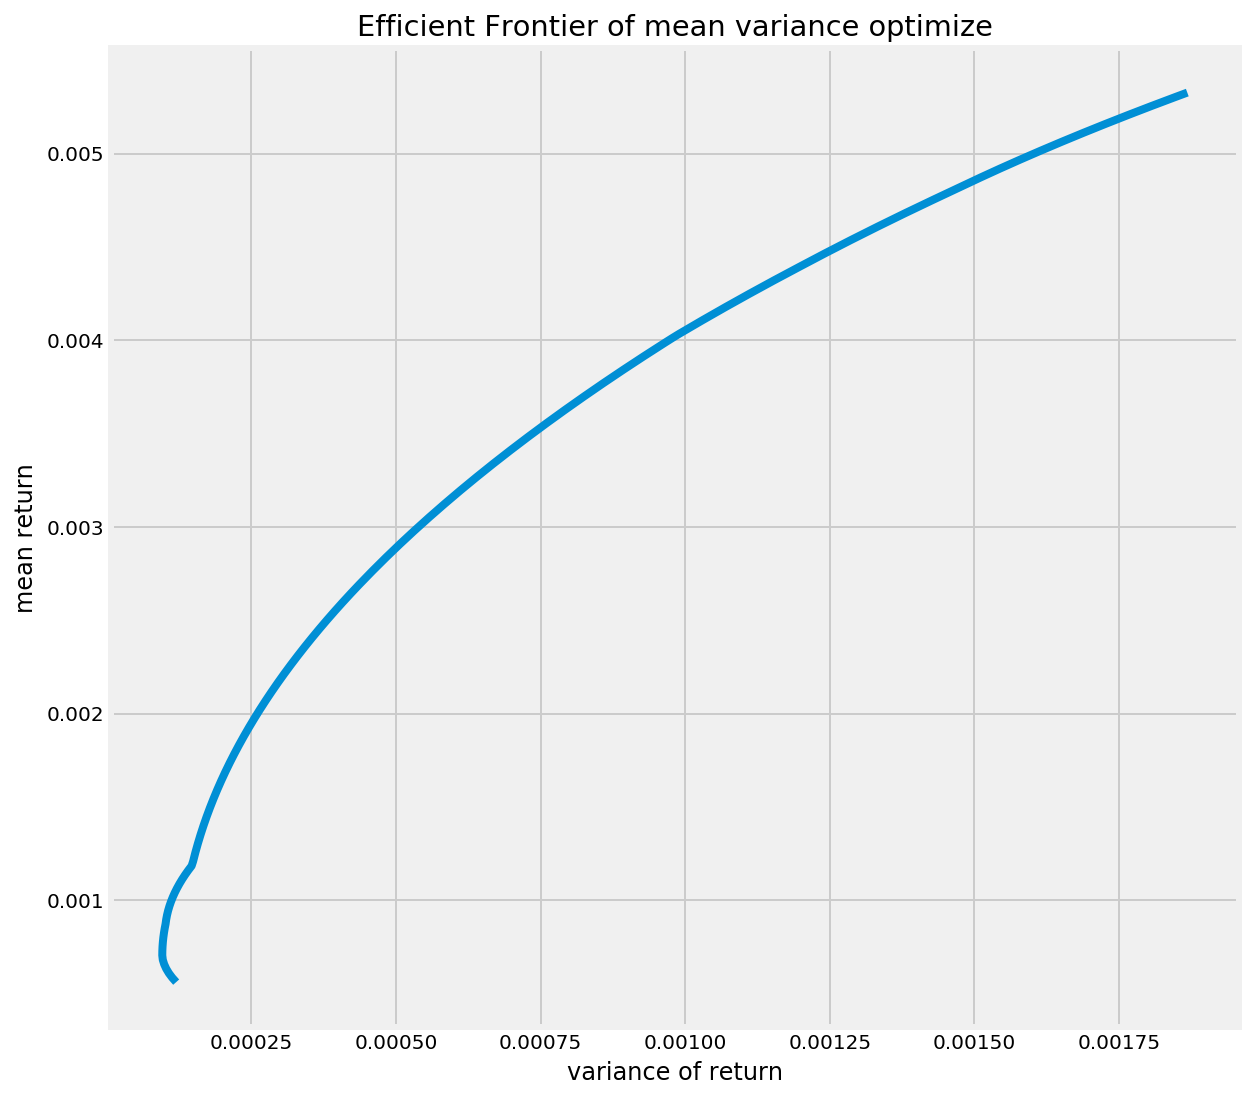

In [21]:
optimize_return = np.array( [] )
optimize_risk = np.array( [] )
for target in np.arange( min_value , max_value , diff_value ):
    result = maximum_optimization( mean_returns , cov_matrix , target )
    port_variance , port_return = portfolio_annualised_performance( result.x, mean_returns, cov_matrix)
    optimize_return = np.append( 
            optimize_return,
            port_return )
    optimize_risk = np.append(
            optimize_risk,
            port_variance )
    
plt.figure(figsize = ( 9 , 9 ))
plt.plot( expect_return_risk , expect_return_return )
plt.title('Efficient Frontier of mean variance optimize')
plt.xlabel( "variance of return")
plt.ylabel( "mean return")
plt.show()   